In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


## Preprocessing ##

### import packages and setup ###

In [4]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_predict, cross_validate

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [24]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


look at correlation between features

<Axes: >

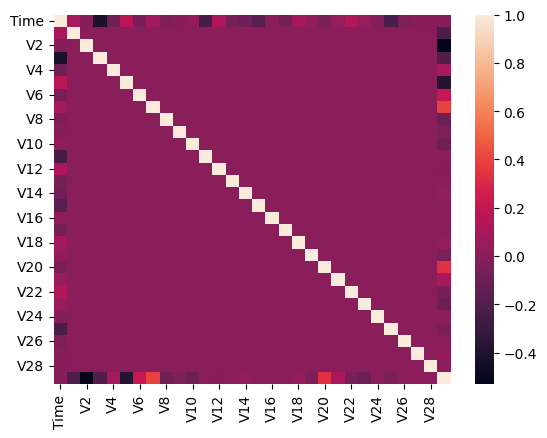

In [25]:
sns.heatmap(df.iloc[:,:-1].corr())

correlation is close to 0 for pairs of feature, which makes sense given these are principle components.

take a look at the distribution of non-principle component features -- time and amount

In [26]:
# assign id to each transaction
df['id'] = [i for i in range(len(df))]

# put time and amount in to bins
df['time_strata'] = pd.cut(df.Time, [i * 20000 for i in range(10)])
df['amount_strata'] = pd.cut(df.Amount, [i * 2000 for i in range(13)])

df_time_group = df.groupby('time_strata').aggregate({'Class': 'sum', 'id': 'count'})
df_time_group['percentage'] = df_time_group['Class'].divide(df_time_group['id'])

df_amount_group = df.groupby('amount_strata').aggregate({'Class': 'sum', 'id': 'count'})
df_amount_group['percentage'] = df_amount_group['Class'].divide(df_amount_group['id'])

/tmp/ipykernel_33/3892099621.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_time_group = df.groupby('time_strata').aggregate({'Class': 'sum', 'id': 'count'})
/tmp/ipykernel_33/3892099621.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_amount_group = df.groupby('amount_strata').aggregate({'Class': 'sum', 'id': 'count'})


<Axes: xlabel='time_strata'>

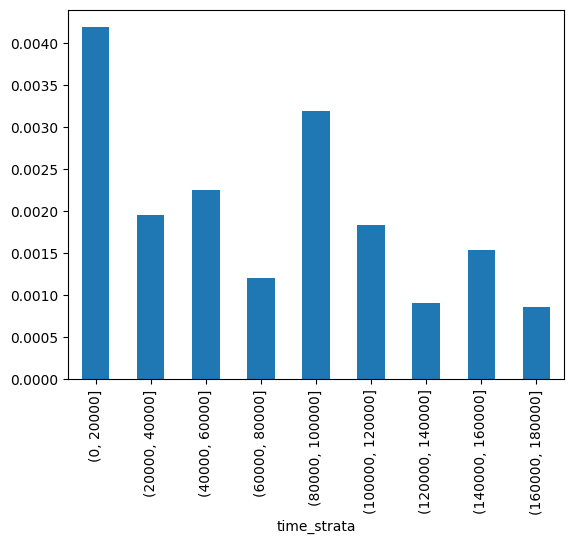

In [27]:
df_time_group['percentage'].plot(kind='bar')

from the above, we can see that fraud occurs in the early stage the most, with 80000-100000 seconds being another frequent stage

<Axes: xlabel='amount_strata'>

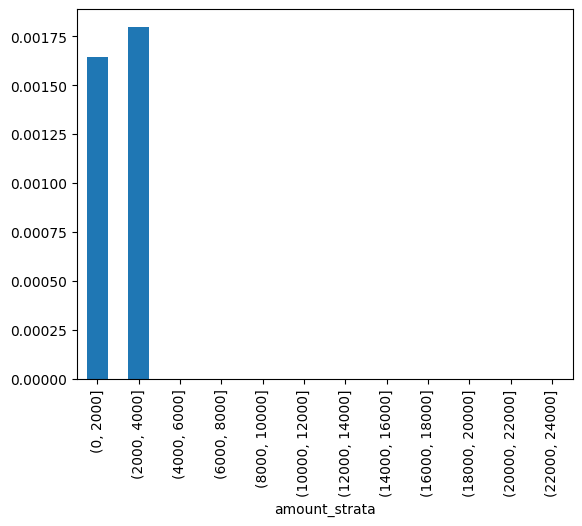

In [28]:
df_amount_group['percentage'].plot(kind='bar')

it looks like fraud doesn't happen with large amounts.

look at the distribution of each feature

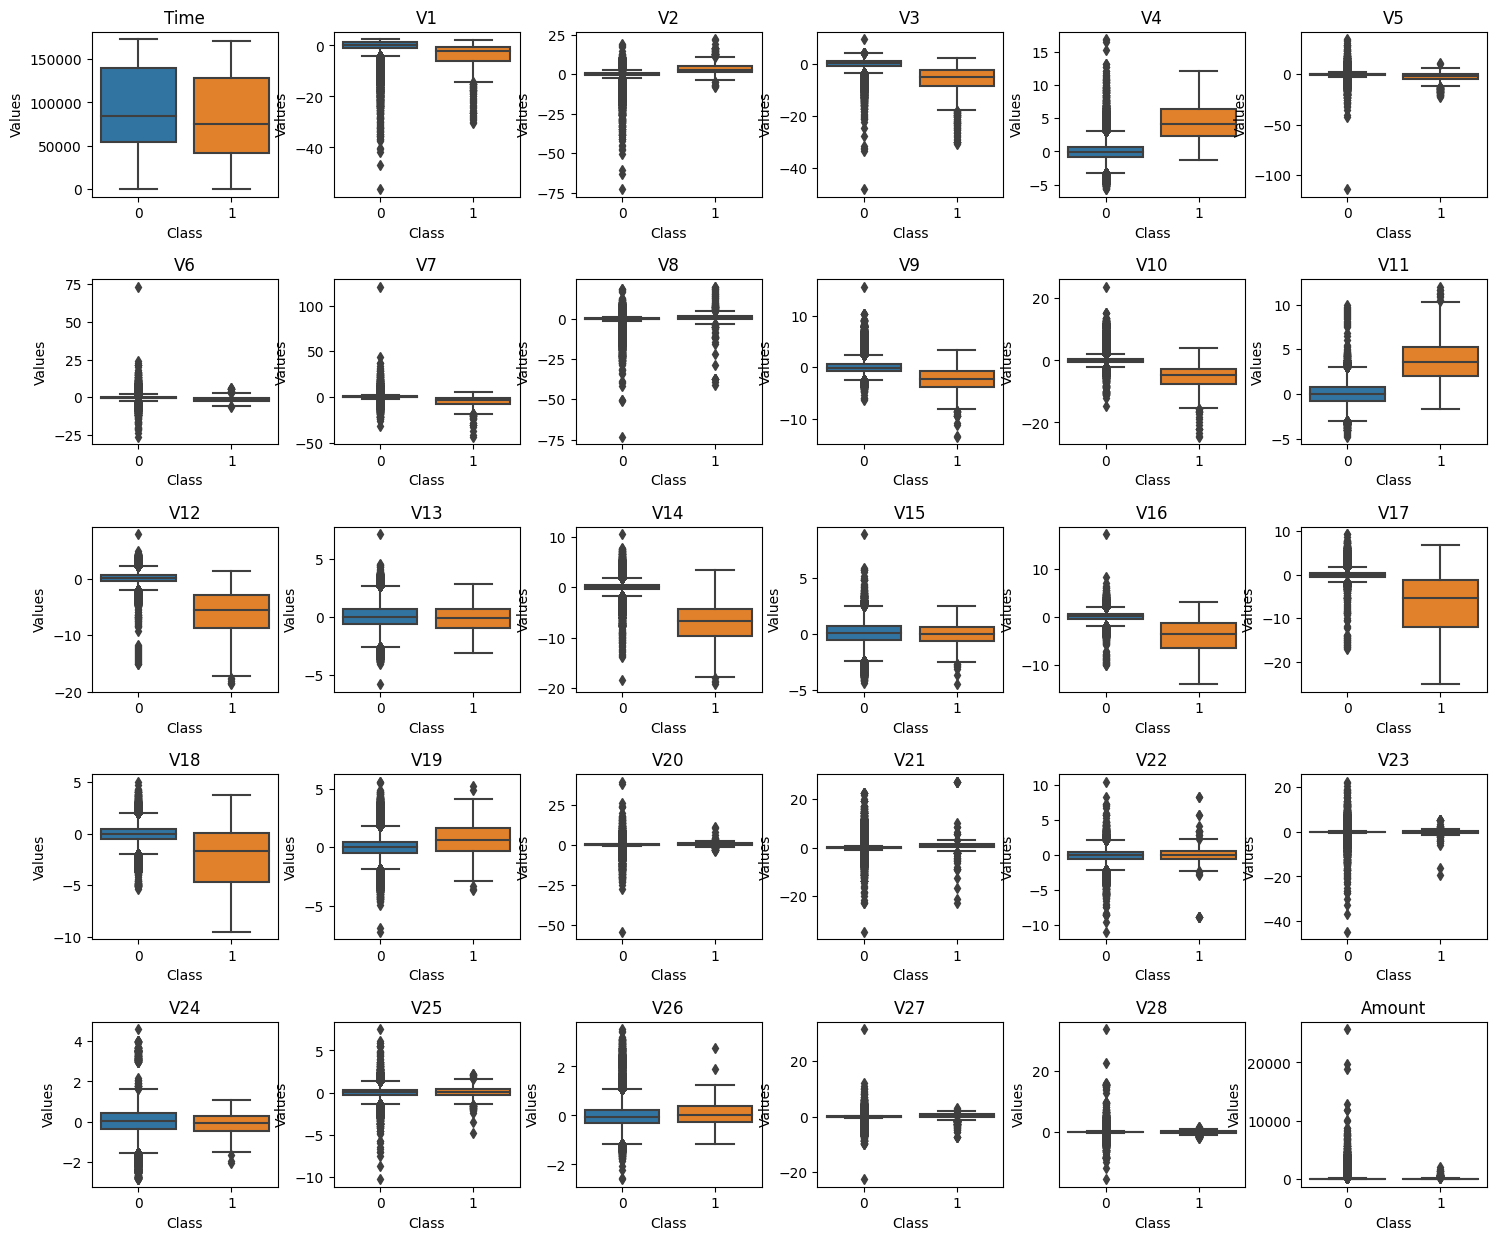

In [5]:
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(18, 15))

for i, col in enumerate(list(df.columns[:-1])):
    # Calculate the row and column index for the subplot
    r = i // 6
    c = i % 6
    
    # Plot the boxplot in the corresponding subplot
    #df.boxplot(column=col, ax=axes[r][c], grid=False)
    sns.boxplot(x='Class', y=col, data=df, ax=axes[r][c])
    
    # Set the title and y-axis label for the subplot
    axes[r][c].set_title(col)
    axes[r][c].set_ylabel('Values')
    
# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Display the plot
plt.show()


We can see that a lot of these features have outliers present. Let's take a deeper look.

In [11]:
def analyze_outliers(df, columns):
    # Loop through each column
    dict_out = {'outlier_count':[], 'fraud_outlier_count':[]}
    for col in columns:
        # Calculate the first and third quartiles of the column
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        
        # Calculate the interquartile range (IQR)
        iqr = q3 - q1
        
        # Calculate the lower and upper bounds for outliers
        lower_bound = q1 - 1.5*iqr
        upper_bound = q3 + 1.5*iqr
        
        is_outlier = df[col].apply(lambda x: True if x < lower_bound or x > upper_bound else False)
        is_outlier_fraud = [True if is_outlier[i] and df['Class'].values[i] == 1 else False for i in range(len(df))]
        
        dict_out['outlier_count'].append(np.sum(is_outlier))
        dict_out['fraud_outlier_count'].append(np.sum(is_outlier_fraud))
        
    return pd.DataFrame(dict_out, index=columns)
    

In [13]:
analyze_outliers(df, df.columns[:-1])

,outlier_count,fraud_outlier_count
Time,0,0
V1,7062,174
V2,13526,246
V3,3363,312
V4,11148,318
V5,12295,208
V6,22965,137
V7,8948,301
V8,24134,247
V9,8283,223


In [9]:
print('Fraud size:', df[df['Class'] == 1].shape[0])
print('Non-Fraud size:', df[df['Class'] == 0].shape[0])

Fraud size: 492
Non-Fraud size: 284315


Because the features underwent PCA and we can't infer the cause of them, we cannot process them by modifying them to a lower or upper bound or dropping them. We will keep the results in mind for now.

Also, because the fraud class is highly imbalanced (284k vs 492), we can try downsampling the class zero data for the model to pay more attention to class one.

In [14]:
# under sample non-fraud class
df_non_fraud = df[df['Class'] == 0].sample(n=2000, random_state=42)
df_under = pd.concat([df_non_fraud, df[df['Class'] == 1]])

In [15]:
y = df['Class']
X = df.drop('Class', axis=1)

y_under = df_under['Class']
X_under = df_under.drop('Class', axis=1)

### split data ###

We will still keep the original data and see how undersampling affect the results.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_under, y_under, test_size=0.2, random_state=42, stratify=y_under)

In [18]:
# check ratio of fraud class in train and test and make sure they are roughly the same
print(np.sum(y_train)/len(X_train), np.sum(y_test)/len(X_test))

0.001729245759178389 0.0017204452090867595


### functions for evaluation ###

In [19]:
def pr_plot_curve_find_threshold(y_true, y_pred):
    '''
    plot precision and recall curve and find the optimal cutoff (where precision and recall intersect)
    '''
    p, r, thresholds = precision_recall_curve(y_true, y_pred)

    plt.plot(thresholds, p[:-1],  'g--', label='precision')
    plt.plot(thresholds, r[:-1], 'b--', label='recall')
    plt.legend()
    plt.title('Precision vs. Recall')
    plt.show()
    
    diff = r-p
    idx = np.argmin(diff[diff>=0])
    thresh = thresholds[idx]
    
    return thresh

In [20]:
def get_perf_metrics(y_actual, y_pred):
    '''
    print performance metrics
    because the target class is very imbalanced, we will pay more attention to precision, recall, and F-1 score
    '''
    p = precision_score(y_actual, y_pred)
    r = recall_score(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred)
    df_conf = pd.DataFrame(confusion_matrix(y_actual, y_pred), index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
    print(f"""
    precision: {p}\n
    recall: {r}\n
    f1-score: {f1}
    """)
    plt.figure(figsize = (6,4))
    sns.heatmap(df_conf, annot=True)

## Predictive Models ##

### random forest ###
try using class weights on original dataset first instead of oversampling or undersampling

In [34]:
clf = RandomForestClassifier(class_weight={0:1, 1:500}, random_state=42)

In [45]:
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1, 1: 500}, random_state=42)

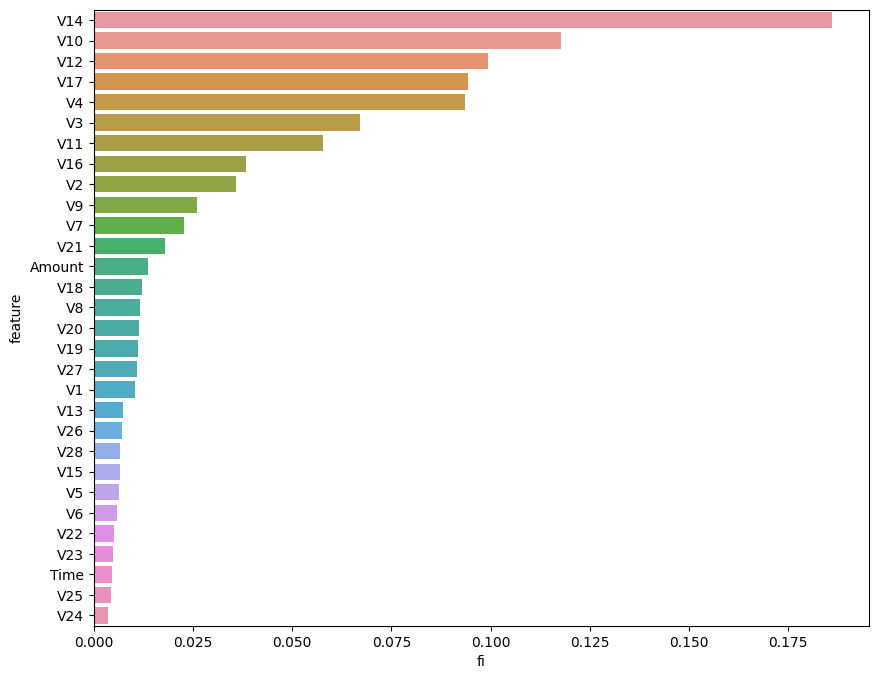

In [46]:
fi = clf.feature_importances_
dict_fi = {'feature': X.columns, 'fi': fi}
df_fi = pd.DataFrame.from_dict(dict_fi).sort_values(by='fi', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(y='feature', x='fi', data=df_fi)
plt.show()

In [47]:
from sklearn.model_selection import cross_val_predict

y_pred_scores = cross_val_predict(clf, X_train, y_train, cv=4, method="predict_proba")
y_pred_scores_p = cross_val_predict(clf, X_train, y_train, cv=4, method="predict")

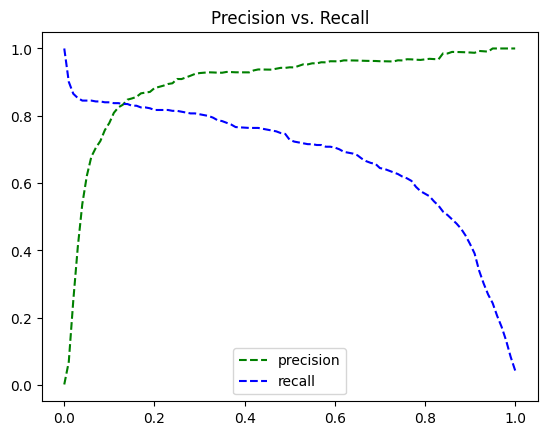

0.13

In [48]:
pr_plot_curve_find_threshold(y_train, y_pred_scores[:,1])


    precision: 0.9615384615384616

    recall: 0.7653061224489796

    f1-score: 0.8522727272727273
    


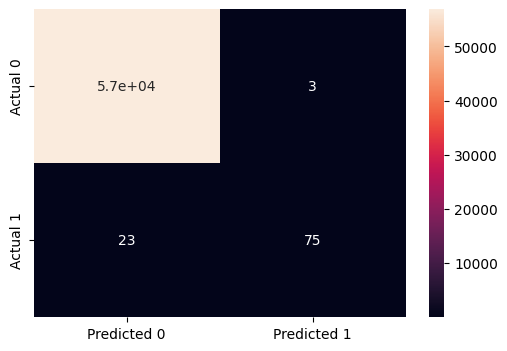

In [49]:
y_test_pred = clf.predict(X_test)
get_perf_metrics(y_test, y_test_pred)


    precision: 0.8723404255319149

    recall: 0.8367346938775511

    f1-score: 0.8541666666666667
    


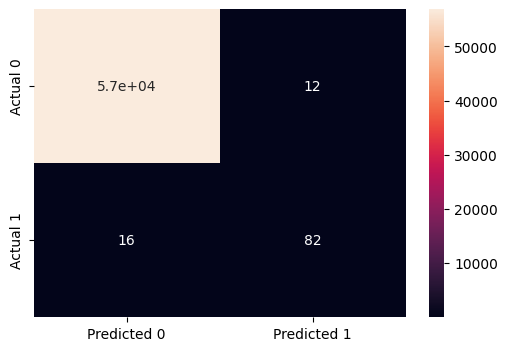

In [50]:
y_test_proba = clf.predict_proba(X_test)
y_test_pred_2 = [1 if i > 0.2 else 0 for i in y_test_proba[:, 1]]

get_perf_metrics(y_test, y_test_pred_2)


    precision: 1.0

    recall: 0.8686868686868687

    f1-score: 0.9297297297297298
    


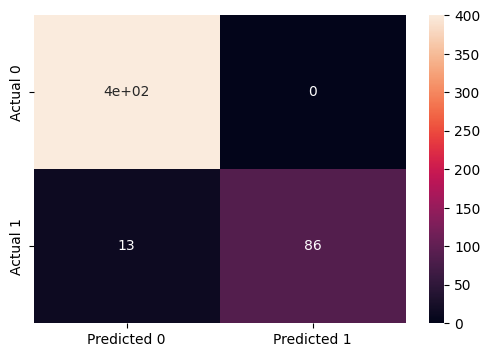

In [21]:
# try training using under-samples set
clf = RandomForestClassifier(class_weight={0:1, 1:4}, random_state=42)
clf.fit(X_train_u, y_train_u)
y_test_pred_u = clf.predict(X_test_u)
get_perf_metrics(y_test_u, y_test_pred_u)

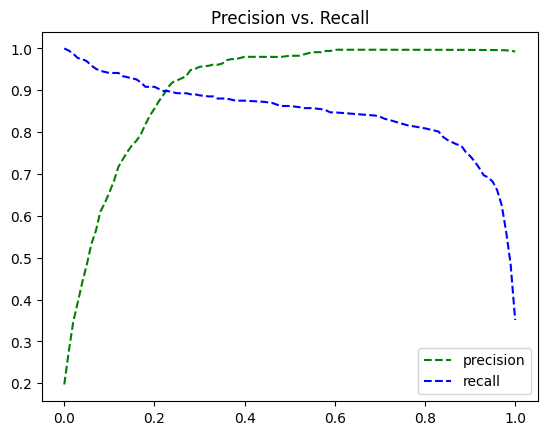

0.22

In [22]:
rf_train_score_u = cross_val_predict(clf, X_train_u, y_train_u, method='predict_proba')
pr_plot_curve_find_threshold(y_train_u, rf_train_score_u[:,1])


    precision: 0.9285714285714286

    recall: 0.9191919191919192

    f1-score: 0.9238578680203046
    


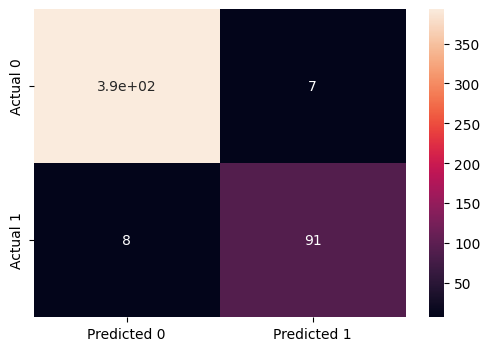

In [23]:
y_test_u_proba = clf.predict_proba(X_test_u)
y_test_pred_u_2 = [1 if i > 0.22 else 0 for i in y_test_u_proba[:, 1]]

get_perf_metrics(y_test_u, y_test_pred_u_2)

#### grid search for hyperparameter tuning ####

In [65]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_features': [2, 10, 20, int(np.sqrt(X_train.shape[1]))],
    'max_depth': [5, 10, 15, 20],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
    'class_weight': [{0:1, 1:20}, {0:1, 1:100}, {0:1, 1:500}, {0:1, 1:1000}, {0:1, 1:2000}]
    
}

rf_grid = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid, random_state=42, scoring='f1') # use default accuracy optimization
rf_grid.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'class_weight': [{0: 1, 1: 20},
                                                         {0: 1, 1: 100},
                                                         {0: 1, 1: 500},
                                                         {0: 1, 1: 1000},
                                                         {0: 1, 1: 2000}],
                                        'max_depth': [5, 10, 15, 20],
                                        'max_features': [2, 10, 20, 5],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 50, 100, 200]},
                   random_state=42, scoring='f1')

In [66]:
rf_grid.best_params_

{'n_estimators': 10,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 10,
 'max_depth': 15,
 'class_weight': {0: 1, 1: 100}}

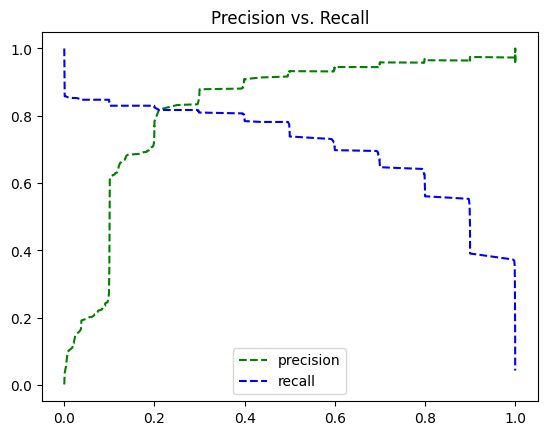

0.2

In [67]:
rf_best = rf_grid.best_estimator_

y_pred_scores_best = cross_val_predict(rf_best, X_train, y_train, cv=4, method="predict_proba")
pr_plot_curve_find_threshold(y_train, y_pred_scores_best[:,1])


    precision: 0.9382716049382716

    recall: 0.7755102040816326

    f1-score: 0.8491620111731844
    


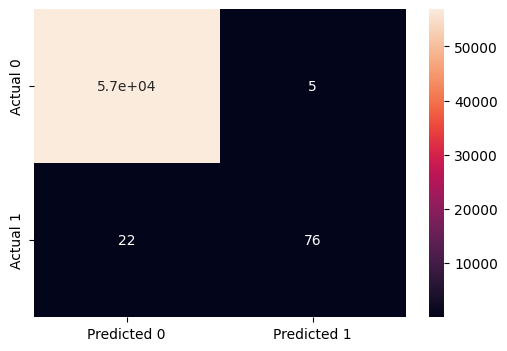

In [68]:
rf_best_test = rf_best.predict(X_test)
get_perf_metrics(y_test, rf_best_test)


    precision: 0.7543859649122807

    recall: 0.8775510204081632

    f1-score: 0.8113207547169812
    


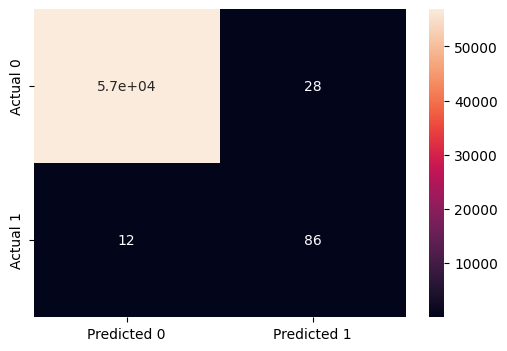

In [69]:
rf_best_test_proba = rf_best.predict_proba(X_test)
rf_best_test_proba = [1 if i > 0.29 else 0 for i in rf_best_test_proba[:, 1]]

get_perf_metrics(y_test, rf_best_test_proba)

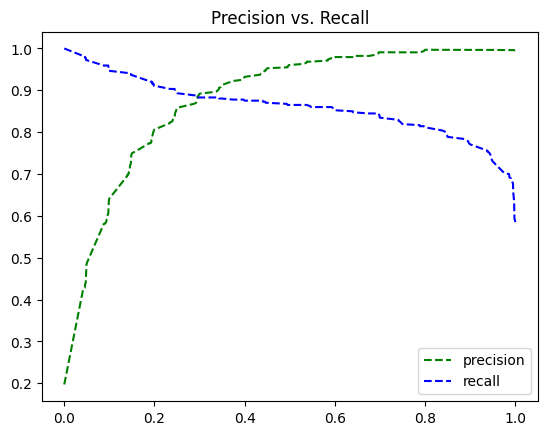

0.29545454545454547

In [37]:
# try under sampled dataset
rf_grid.fit(X_train_u, y_train_u)
rf_best_u = rf_grid.best_estimator_


rf_best_pred_scores_u = cross_val_predict(rf_best_u, X_train_u, y_train_u, cv=4, method="predict_proba")
pr_plot_curve_find_threshold(y_train_u, rf_best_pred_scores_u[:,1])


    precision: 0.9659090909090909

    recall: 0.8585858585858586

    f1-score: 0.9090909090909091
    


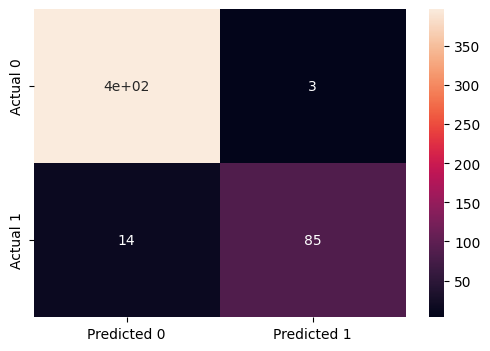

In [40]:
rf_best_test_u = rf_best_u.predict(X_test_u)
get_perf_metrics(y_test_u, rf_best_test_u)


    precision: 0.9270833333333334

    recall: 0.898989898989899

    f1-score: 0.9128205128205129
    


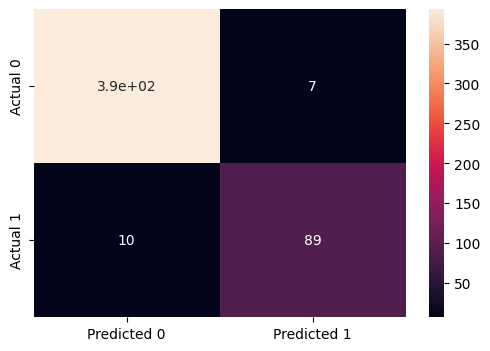

In [64]:
rf_best_test_proba_u = rf_best_u.predict_proba(X_test_u)
rf_best_test_proba_u = [1 if i > 0.30 else 0 for i in rf_best_test_proba_u[:, 1]]

get_perf_metrics(y_test_u, rf_best_test_proba_u)

try using SMOTE

In [70]:
smt = SMOTE(random_state=42)

pipeline = Pipeline(
    steps = [['smote', smt],
             ['rf', RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 200})]]
)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ['rf',
                 RandomForestClassifier(class_weight={0: 1, 1: 200},
                                        random_state=42)]])

In [71]:
rf_smt_scores = cross_val_predict(estimator=pipeline, X=X_train, y=y_train, cv=3, method='predict_proba')

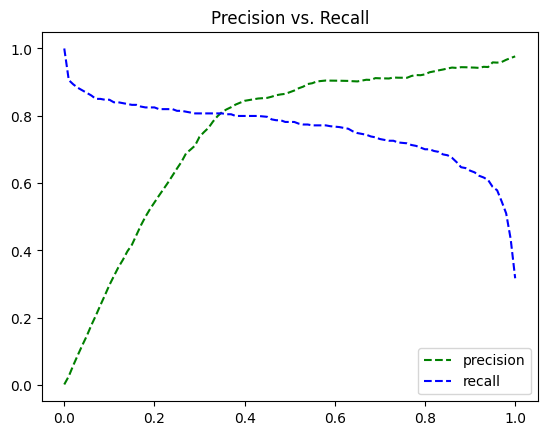

0.34

In [72]:
pr_plot_curve_find_threshold(y_train, rf_smt_scores[:,1])


    precision: 0.8279569892473119

    recall: 0.7857142857142857

    f1-score: 0.806282722513089
    


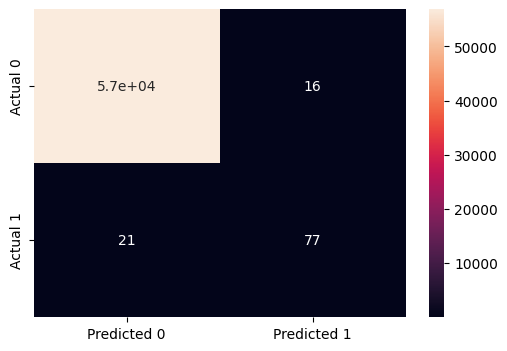

In [73]:
y_test_pred_smt = pipeline.predict(X_test)
get_perf_metrics(y_test, y_test_pred_smt)


    precision: 0.7232142857142857

    recall: 0.826530612244898

    f1-score: 0.7714285714285715
    


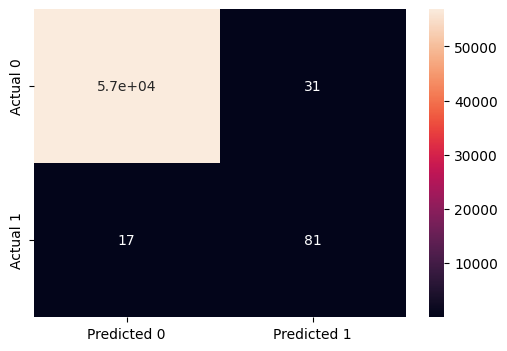

In [74]:
y_test_pred_smt_p = pipeline.predict_proba(X_test)
y_test_pred_smt_p = [1 if i >= 0.34 else 0 for i in y_test_pred_smt_p[:,1]]
get_perf_metrics(y_test, y_test_pred_smt_p)

In [75]:
param_grid_pipe = {
    "rf__n_estimators": [20,50,100, 200],
    "rf__max_depth": [2, 5, 10, 20],
    "rf__class_weight": [{0:1, 1:1}, {0:1, 1:20}, {0:1, 1:100}, {0:1, 1:500}, {0:1, 1:1000}, {0:1, 1:2000}]
}

rf_smt_search = RandomizedSearchCV(
    pipeline, param_grid_pipe, scoring="f1", n_iter=1, n_jobs=-1, cv=5
).fit(X_train, y_train)

In [76]:
rf_smt_search.best_params_

{'rf__n_estimators': 100,
 'rf__max_depth': 2,
 'rf__class_weight': {0: 1, 1: 1000}}


    precision: 0.0017264159253060866

    recall: 1.0

    f1-score: 0.0034468811001881717
    


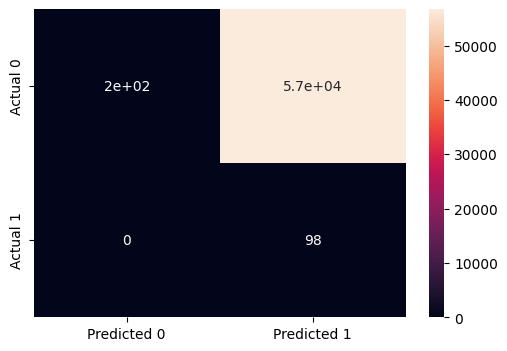

In [77]:
best_rf_smt = rf_smt_search.best_estimator_

y_test_pred_best_rf_smt = best_rf_smt.predict(X_test)
get_perf_metrics(y_test, y_test_pred_best_rf_smt)

In [78]:
best_rf_smt_p = cross_val_predict(best_rf_smt, X=X_train, y=y_train, cv=4, method='predict_proba')

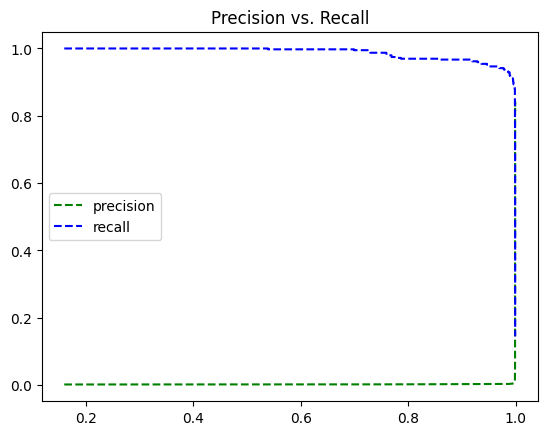

0.999154941635339

In [79]:
pr_plot_curve_find_threshold(y_train, best_rf_smt_p[:,1])


    precision: 0.0017225014940063978

    recall: 1.0

    f1-score: 0.0034390791690061765
    


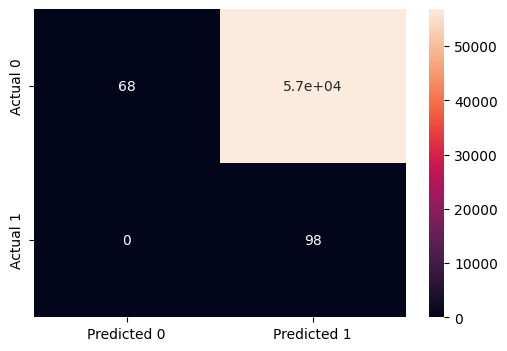

In [80]:
y_test_pred_rf_smt_best = best_rf_smt.predict_proba(X_test)[:,1]
y_test_pred_rf_smt_best = [1 if i > 0.41 else 0 for i in y_test_pred_rf_smt_best]
get_perf_metrics(y_test, y_test_pred_rf_smt_best)

### Adaboost ###

In [81]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)

AdaBoostClassifier()

In [82]:
ada_train_pred = cross_val_predict(ada, X_train, y_train, cv=4, method='predict_proba')

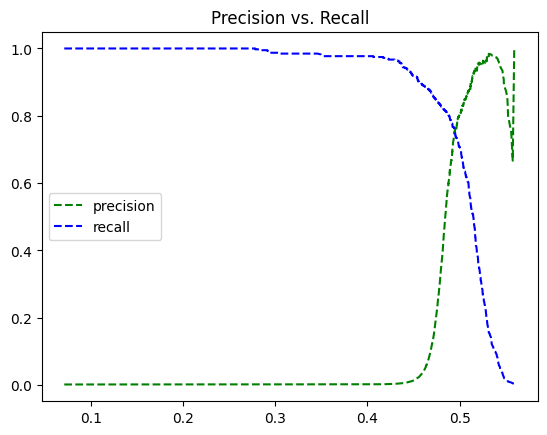

0.49484189456713723

In [83]:
pr_plot_curve_find_threshold(y_train, ada_train_pred[:,1])


    precision: 0.9545454545454546

    recall: 0.8484848484848485

    f1-score: 0.8983957219251337
    


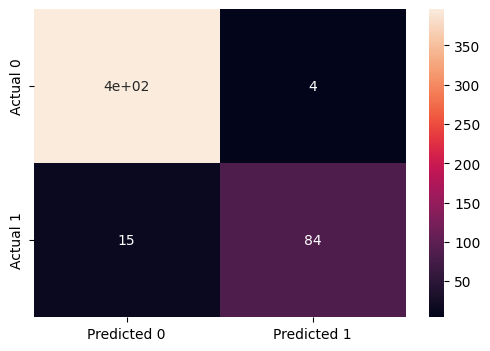

In [45]:
# under sampled 
ada.fit(X_train_u, y_train_u)
ada_pred_u = ada.predict(X_test_u)
get_perf_metrics(y_test_u, ada_pred_u)

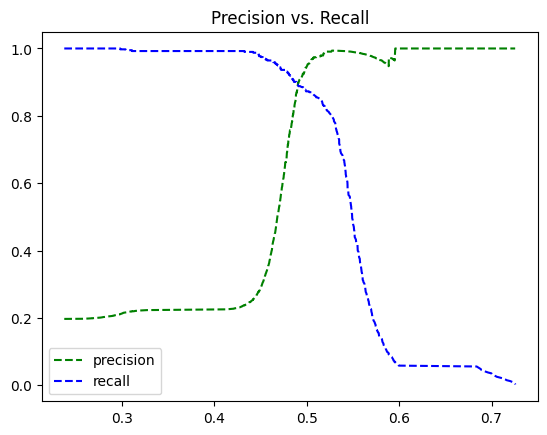

0.4904010897632113

In [48]:
train_ada_scores_u = cross_val_predict(ada, X_train_u, y_train_u, method='predict_proba')
pr_plot_curve_find_threshold(y_train_u, train_ada_scores_u[:,1])


    precision: 0.8476190476190476

    recall: 0.898989898989899

    f1-score: 0.8725490196078433
    


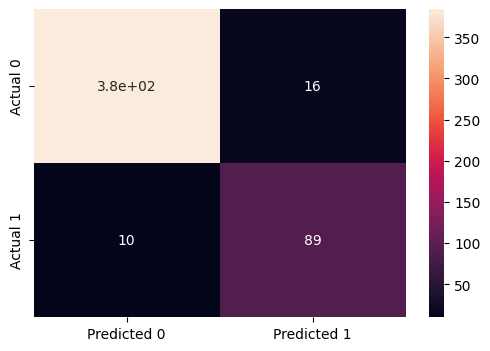

In [49]:
y_test_pred_ada_u = ada.predict_proba(X_test_u)[:,1]
y_test_pred_ada_u = [1 if i > 0.49 else 0 for i in y_test_pred_ada_u]
get_perf_metrics(y_test_u, y_test_pred_ada_u)

### XGBoost ###

first try original dataset

In [50]:
from sklearn.utils.class_weight import compute_sample_weight

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train #provide your own target name
)
np.unique(sample_weights)

array([  0.50086612, 289.14340102])

In [26]:
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, subsample=0.8)#, class_weight=sample_weights)
#xgb.fit(X_train, y_train, sample_weight=sample_weights)
xgb.fit(X_train, y_train)
xgb_train_scores = cross_val_predict(xgb, X_train, y_train, method='predict_proba')

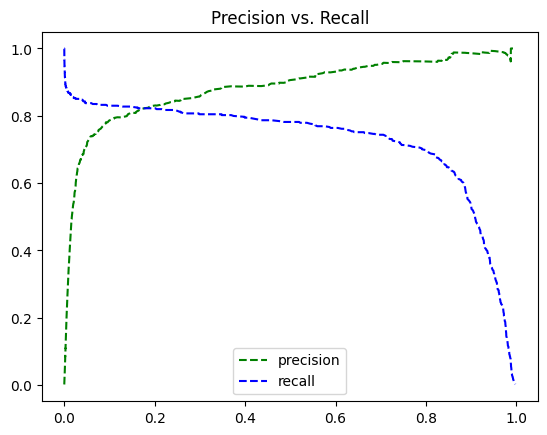

0.17732087

In [28]:
pr_plot_curve_find_threshold(y_train, xgb_train_scores[:,1])
# no sample weights specified


    precision: 0.9080459770114943

    recall: 0.8061224489795918

    f1-score: 0.854054054054054
    


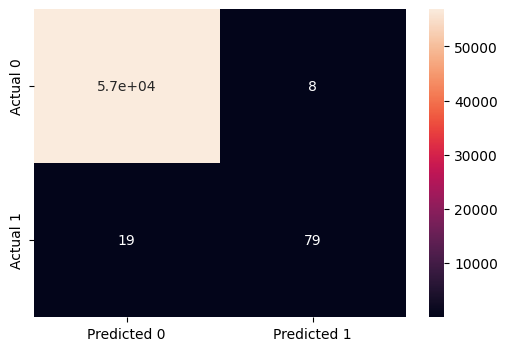

In [29]:
xgb_test_pred = xgb.predict(X_test)
get_perf_metrics(y_test, xgb_test_pred)


    precision: 0.7456140350877193

    recall: 0.8673469387755102

    f1-score: 0.8018867924528301
    


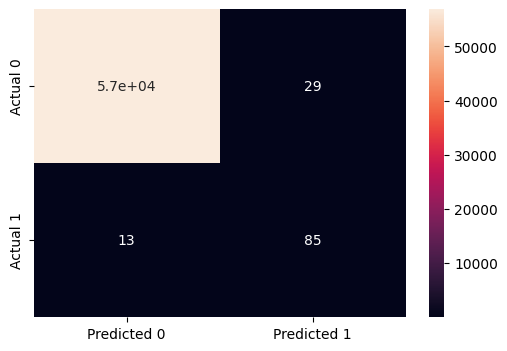

In [30]:
xgb_test_pred = xgb.predict_proba(X_test)[:,1]
xgb_test_pred = [1 if i > 0.158 else 0 for i in xgb_test_pred]
get_perf_metrics(y_test, xgb_test_pred)

In [31]:
param_grid = {
    'n_estimators': [20, 50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7],
    #'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 100}, {0: 1, 1: 500}]
}

xgb_search = RandomizedSearchCV(XGBClassifier(), param_grid, scoring='f1').fit(X_train, y_train)

In [32]:
xgb_search.best_params_

{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}

In [33]:
best_xgb = xgb_search.best_estimator_
train_pred_best_sgb_scores = cross_val_predict(best_xgb, X_train, y_train, method='predict_proba')

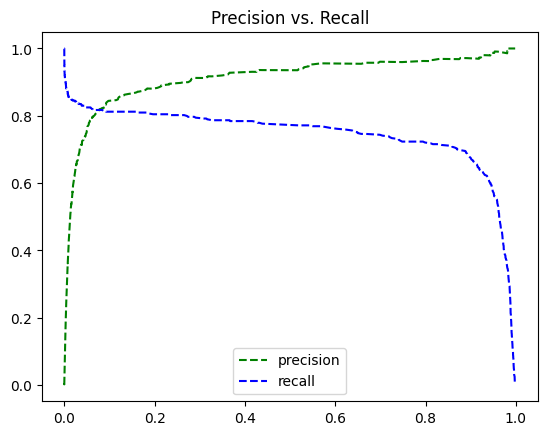

0.0771892

In [34]:
pr_plot_curve_find_threshold(y_train, train_pred_best_sgb_scores[:,1])


    precision: 0.8977272727272727

    recall: 0.8061224489795918

    f1-score: 0.849462365591398
    


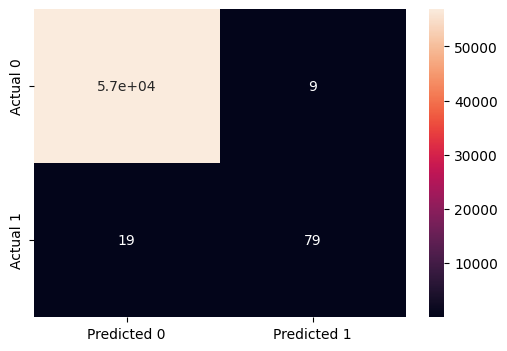

In [35]:
xgb_test_pred_best = best_xgb.predict(X_test)
#xgb_test_pred = [1 if i > 0.158 else 0 for i in xgb_test_pred]
get_perf_metrics(y_test, xgb_test_pred_best)


    precision: 0.8316831683168316

    recall: 0.8571428571428571

    f1-score: 0.8442211055276382
    


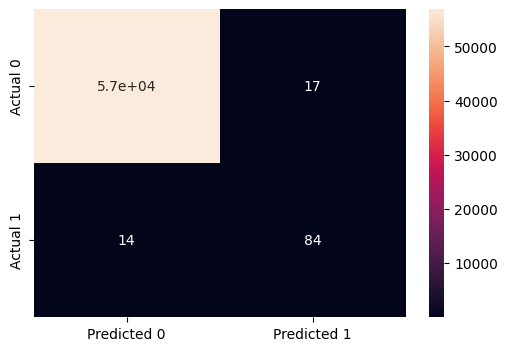

In [36]:
xgb_test_pred_best = best_xgb.predict_proba(X_test)
xgb_test_pred_best = [1 if i > 0.13 else 0 for i in xgb_test_pred_best[:,1]]
get_perf_metrics(y_test, xgb_test_pred_best)

try undersampled dataset


    precision: 0.9775280898876404

    recall: 0.8787878787878788

    f1-score: 0.9255319148936169
    


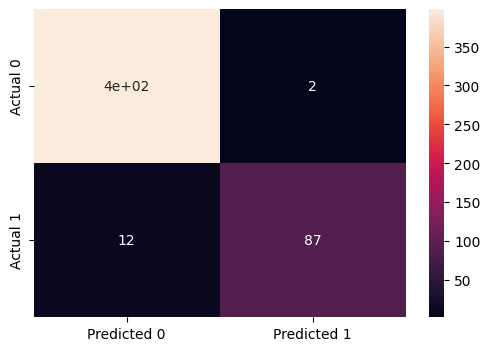

In [52]:
xgb.fit(X_train_u, y_train_u)
test_pred_xgb_u = xgb.predict(X_test_u)
get_perf_metrics(y_test_u, test_pred_xgb_u)

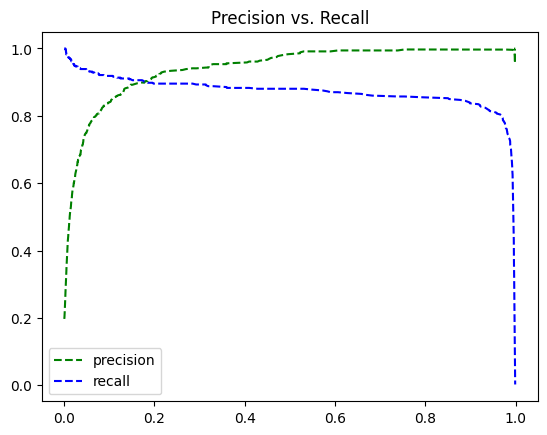

0.17886433

In [54]:
train_scores_xgb_u = cross_val_predict(xgb, X_train_u, y_train_u, method='predict_proba')
pr_plot_curve_find_threshold(y_train_u, train_scores_xgb_u[:,1])


    precision: 0.9019607843137255

    recall: 0.9292929292929293

    f1-score: 0.9154228855721392
    


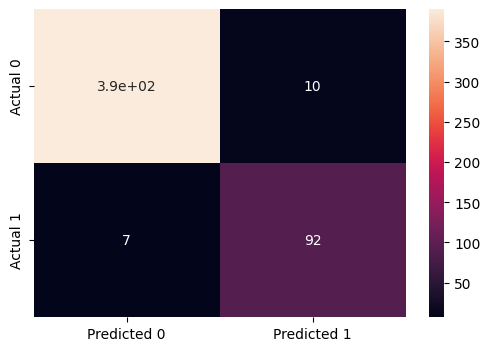

In [55]:
y_test_pred_xgb_u = xgb.predict_proba(X_test_u)[:,1]
y_test_pred_xgb_u = [1 if i > 0.18 else 0 for i in y_test_pred_xgb_u]
get_perf_metrics(y_test_u, y_test_pred_xgb_u)

In [60]:
xgb_search = RandomizedSearchCV(XGBClassifier(), param_grid, scoring='f1').fit(X_train_u, y_train_u)
best_xgb_u = xgb_search.best_estimator_


    precision: 1.0

    recall: 0.8686868686868687

    f1-score: 0.9297297297297298
    


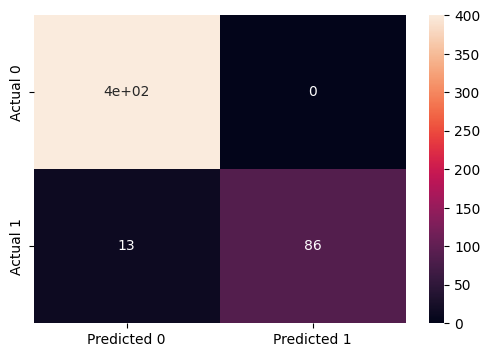

In [61]:
test_pred_best_xgb_u = best_xgb_u.predict(X_test_u)
get_perf_metrics(y_test_u, test_pred_best_xgb_u)

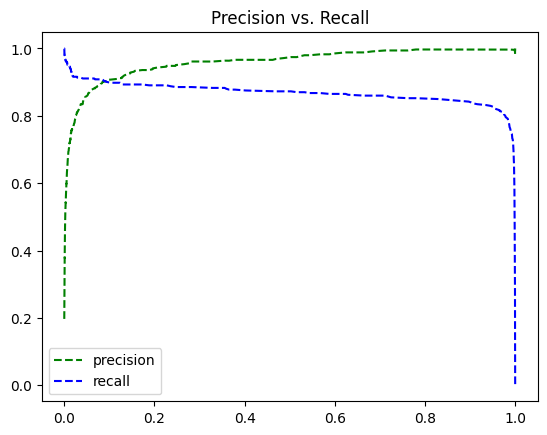

0.09141083

In [62]:
train_scores_best_xgb_u = cross_val_predict(best_xgb_u, X_train_u, y_train_u, method='predict_proba')
pr_plot_curve_find_threshold(y_train_u, train_scores_best_xgb_u[:,1])


    precision: 0.900990099009901

    recall: 0.9191919191919192

    f1-score: 0.91
    


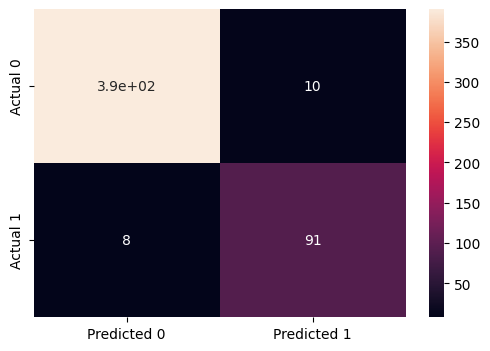

In [63]:
y_test_pred_best_xgb_u = best_xgb_u.predict_proba(X_test_u)[:,1]
y_test_pred_best_xgb_u = [1 if i > 0.09 else 0 for i in y_test_pred_best_xgb_u]
get_perf_metrics(y_test_u, y_test_pred_best_xgb_u)

### logistic regression ###

In [17]:
# normalize data
from sklearn.preprocessing import MinMaxScaler

X_under_norm = MinMaxScaler().fit_transform(X_under)
X_train_u_norm, X_test_u_norm, y_train_u, y_test_u = train_test_split(X_under_norm, y_under, test_size=0.2, random_state=42, stratify=y_under)

In [18]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(verbose=1, class_weight='balanced')
lgr.fit(X_train_u, y_train_u)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38144D+03    |proj g|=  7.22260D+06

At iterate   50    f=  4.75849D+02    |proj g|=  4.68734D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     76     90      1     0     0   3.324D+02   3.644D+02
  F =   364.44922407136255     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


LogisticRegression(class_weight='balanced', verbose=1)

In [19]:
from sklearn.model_selection import cross_validate

scores = cross_validate(lgr, X_train_u, y_train_u, cv=5, scoring=['roc_auc', 'f1'], return_train_score=True)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10488D+03    |proj g|=  6.23785D+06

At iterate   50    f=  3.59770D+02    |proj g|=  6.55873D+03

At iterate  100    f=  2.40434D+02    |proj g|=  1.72929D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31    100    118      1     0     0   1.729D+05   2.404D+02
  F =   240.43383426418362     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10488D+03    |proj g|=  5.82776D+06

At iterate   50    f=  3.83933D+02    |proj g|=  2.75659D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     98    110      1     0     0   6.511D+01   2.869D+02
  F =   286.94524468038514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10488D+03    |proj g|=  6.37807D+06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     48     54      1     0     0   1.035D+02   3.776D+02
  F =   377.58070661737423     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.
 This problem is unconstrained.


In [20]:
scores

{'fit_time': array([0.20823193, 0.07693744, 0.04700422, 0.06272388, 0.0573895 ]),
 'score_time': array([0.03050637, 0.01838708, 0.01702189, 0.01688552, 0.01769614]),
 'test_roc_auc': array([0.95783228, 0.96325158, 0.96202532, 0.97560096, 0.97944712]),
 'train_roc_auc': array([0.98426055, 0.9759579 , 0.95722781, 0.97371776, 0.97357639]),
 'test_f1': array([0.87116564, 0.8313253 , 0.8       , 0.89873418, 0.85542169]),
 'train_f1': array([0.8820827 , 0.87311178, 0.85847589, 0.87022901, 0.86786787])}

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10488D+03    |proj g|=  6.23785D+06

At iterate   50    f=  3.59770D+02    |proj g|=  6.55873D+03

At iterate  100    f=  2.40434D+02    |proj g|=  1.72929D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31    100    118      1     0     0   1.729D+05   2.404D+02
  F =   240.43383426418362     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10557D+03    |proj g|=  4.79646D+06

At iterate   50    f=  3.85772D+02    |proj g|=  1.85066D+05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   31     66     80      1     0     0   5.789D+01   2.993D+02
  F =   299.30892878871038     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


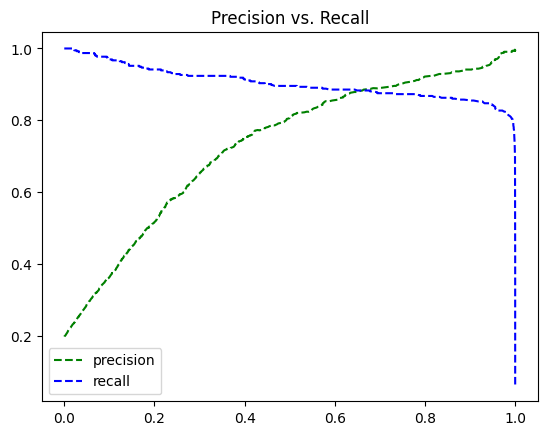

0.6614066000210665

In [21]:
lgr_train_pred_scores_u = cross_val_predict(lgr, X_train_u, y_train_u, method='predict_proba', verbose=0)
pr_plot_curve_find_threshold(y_train_u, lgr_train_pred_scores_u[:,1])


    precision: 0.9

    recall: 0.9090909090909091

    f1-score: 0.9045226130653266
    


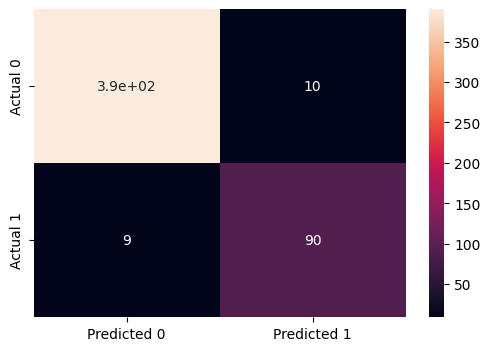

In [22]:
lgr_test_pred_u = lgr.predict(X_test_u)
get_perf_metrics(y_test_u, lgr_test_pred_u)


    precision: 0.9473684210526315

    recall: 0.9090909090909091

    f1-score: 0.9278350515463918
    


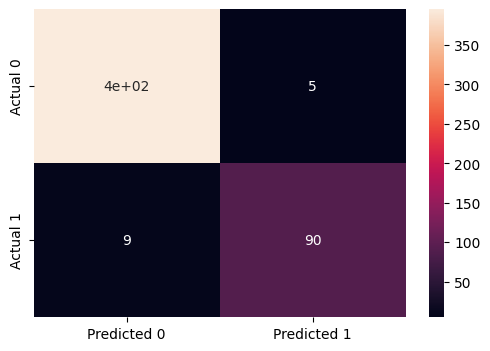

In [23]:
lgr_test_pred_p_u = lgr.predict_proba(X_test_u)[:,1]
lgr_test_pred_p_u = [1 if i > 0.66 else 0 for i in lgr_test_pred_p_u]
get_perf_metrics(y_test_u, lgr_test_pred_p_u)

### SVM ###

In [18]:
from sklearn.svm import LinearSVC, SVC

In [19]:
linearSVC = LinearSVC(C=0.8)
linearSVC.fit(X_train_u_norm, y_train_u)

LinearSVC(C=0.8)

In [20]:
cross_validate(linearSVC, X_train_u_norm, y_train_u, cv=5, scoring='f1', return_train_score=True)

{'fit_time': array([0.02990937, 0.06402564, 0.04741812, 0.04887533, 0.07195854]),
 'score_time': array([0.00648975, 0.00442505, 0.00427461, 0.0069592 , 0.00443697]),
 'test_score': array([0.88111888, 0.90410959, 0.93959732, 0.88571429, 0.91666667]),
 'train_score': array([0.91349481, 0.91222031, 0.9100346 , 0.91222031, 0.91222031])}


    precision: 1.0

    recall: 0.8585858585858586

    f1-score: 0.9239130434782609
    


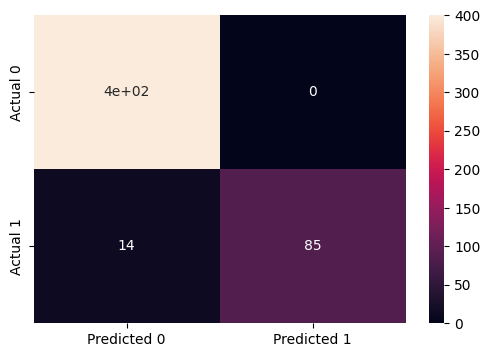

In [21]:
linsvc_train_pred = linearSVC.predict(X_test_u_norm)
get_perf_metrics(y_test_u, linsvc_train_pred)


    precision: 0.9880952380952381

    recall: 0.8383838383838383

    f1-score: 0.907103825136612
    


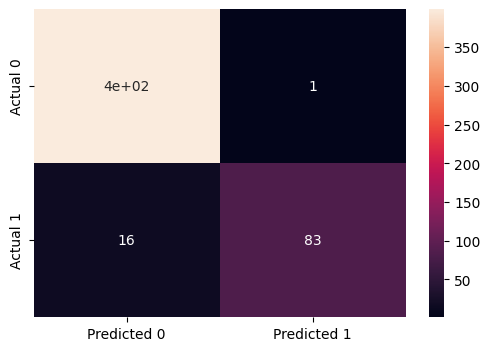

In [25]:
svc = SVC(kernel='poly', C=0.7, degree=2)
svc.fit(X_train_u_norm, y_train_u)
svc_train_pred = svc.predict(X_test_u_norm)
get_perf_metrics(y_test_u, svc_train_pred)

Overall, we can see that logistic regression and XGBoost provides the best results. We also observe that performance using undersampled dataset is better than original. Probability should be further adjusted given expert judgement, especially in the case of fraud, false negatives should be minimized as much as possible.

### Unsupervised -- Isolation Forest ###

Let's see what unsupervised learning can give us by detecting outliers.

In [29]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest()
iforest_train_pred = iforest.fit_predict(X_train)


    precision: 0.03961783439490446

    recall: 0.7893401015228426

    f1-score: 0.07544881125667154
    


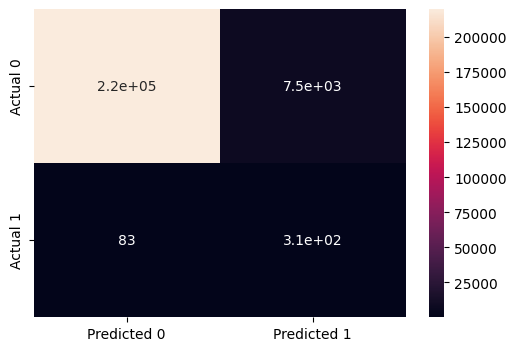

In [30]:
iforest_train_pred = [1 if i == -1 else 0 for i in iforest_train_pred]
get_perf_metrics(y_train, iforest_train_pred)

Isolation forest seems to pick up too many false positives.